<a href="https://colab.research.google.com/github/kavyajeetbora/Image-Classification/blob/master/CIFAR10/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Outline 

1. Load the dataset and visualise
2. add batchnorm layers
3. Comparison with and without batch normalization layers
4. Add Dropout layer
5. Comparison with and without dropout layers

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torchvision import transforms
import torchvision.models as models

from tqdm import tqdm_notebook
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device                

device(type='cuda', index=0)

## 2. Dataset and visualization

In [0]:
transform = transforms.Compose([
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                
])

In [39]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [0]:
datasets = {'train':train_dataset, 'validation': validation_dataset}
dataloaders = {'train':train_loader, 'validation': validation_loader}

In [42]:
sample_image, sample_label = train_dataset[0]
print(sample_image.size(), sample_label)

torch.Size([3, 32, 32]) 6


In [0]:
classes = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

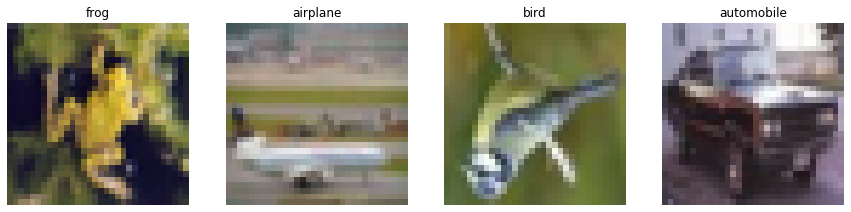

In [44]:
def show_batch_images(dataloader, no_images=4):
  images,labels = iter(dataloader).next()
  plt.figure(figsize=(15,10))
  
  for i, (img,label) in enumerate(zip(images[0:no_images],labels[0:no_images])):
    img = np.transpose(img.numpy(), (1,2,0))
    ax = plt.subplot(1,no_images,i+1)
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(classes[label.item()])
    ax.axis('off')
 
  plt.show()
  
show_batch_images(train_loader)

In [0]:
def return_accuracy(data_loader,model):
  correct = 0
  total = 0
  model.eval()
  for images,labels in data_loader:
    images,labels = images.to(device), labels.to(device)
    total += len(images)
    correct += torch.sum(torch.argmax(model(images),dim=1)==labels).item()
  return correct/total*100

## 3. Defining CNN model Architecture

In [46]:
images, labels = next(iter(train_loader))
print(images.size())

torch.Size([128, 3, 32, 32])


In [0]:
class SimpleConvNet(nn.Module):
  def __init__(self):
    super(SimpleConvNet,self).__init__()
    self.c1 = self.convolution(filters=32, dropout=0.2)
    self.c2 = self.convolution(input_channels= 32, filters=64, dropout=0.3)
    self.c3 = self.convolution(input_channels=64, filters=128, dropout=0.4)
    self.fc = nn.Sequential(
        nn.Linear(128*4*4,10)
    )

  def forward(self, X):
    c1 = self.c1(X)
    c2 = self.c2(c1)
    c3 = self.c3(c2)
    c3 = c3.view(X.size()[0],-1)
    fc1 = self.fc(c3)
    return fc1

  def convolution(self, input_channels=3, filters = 64, dropout=0.2):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=filters, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(filters),
        nn.Conv2d(in_channels=filters,out_channels=filters,kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(filters),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout2d(dropout)
    )
    return conv

In [48]:
net = SimpleConvNet()
net

SimpleConvNet(
  (c1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (c2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=

### Training

In [0]:
def train(model, optimizer, loss_fn, epochs=10, device=device, scheduler=None):
  start_time = time.time()
  best_acc = 0
  best_model_wts = model.state_dict()
  
  train_loss = []
  val_loss = []
  
  train_acc = []
  val_acc = []
  
  model = model.to(device)

  for epoch in tqdm_notebook(range(epochs)):
    print('Epoch {}/{}'.format(epoch,epochs))
    print('-'*20)
    
    for phase in ['train', 'validation']:
        
      ## 1. setting up the training mode 
      if phase == 'train':
        model.train(True)
      else:
        model.train(False)
          
      running_loss = 0.0
      running_corrects = 0.0
      running_batch = 0.0
      
      for data in dataloaders[phase]:
        images,labels = data
        images,labels = images.to(device), labels.to(device)
        
        ## zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        output = model(images)
        loss = loss_fn(output,labels)
        preds = torch.argmax(output,dim=1)

        if phase == 'train':
          loss.backward()
          optimizer.step()

        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds==labels)
        running_batch += 1
    
      epoch_loss = running_loss/running_batch
      epoch_accuracy = running_corrects/len(datasets[phase])
          
      # store the statistics for plotting and step lr scheduler
      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_accuracy)
      else:
        val_loss.append(epoch_loss)
        val_acc.append(epoch_accuracy)
        if scheduler is not None:
          scheduler.step(epoch_accuracy)


      print('{} Loss {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
          
      ## save the best model
      if phase == 'validation' and epoch_accuracy > best_acc:
        best_acc = epoch_accuracy
        best_model_wts = model.state_dict()

  time_elapsed = time.time() - start_time    
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best validation accuracy {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  
  
  ## plot the statistics
  fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, sharex=True)
  
  ax1.plot(train_loss)
  ax1.plot(val_loss)
  ax1.set_title('Cross Entropy loss')
  ax1.set_xlabel('Epochs')
  
  ax2.plot(train_acc)
  ax2.plot(val_acc)
  ax2.set_title('Accuracy (%)')
  ax2.set_xlabel('Epochs')
  
  return model

Epoch 0/100
--------------------
train Loss 1.6929 Acc: 0.3925
validation Loss 1.3563 Acc: 0.5053
Epoch 1/100
--------------------
train Loss 1.3434 Acc: 0.5185
validation Loss 1.2059 Acc: 0.5553
Epoch 2/100
--------------------
train Loss 1.1807 Acc: 0.5800
validation Loss 1.0041 Acc: 0.6418
Epoch 3/100
--------------------
train Loss 1.0733 Acc: 0.6207
validation Loss 0.9965 Acc: 0.6452
Epoch 4/100
--------------------
train Loss 0.9898 Acc: 0.6495
validation Loss 0.8808 Acc: 0.6910
Epoch 5/100
--------------------
train Loss 0.9367 Acc: 0.6690
validation Loss 0.8236 Acc: 0.7080
Epoch 6/100
--------------------
train Loss 0.8980 Acc: 0.6827
validation Loss 0.7612 Acc: 0.7320
Epoch 7/100
--------------------
train Loss 0.8583 Acc: 0.6987
validation Loss 0.7571 Acc: 0.7339
Epoch 8/100
--------------------
train Loss 0.8288 Acc: 0.7074
validation Loss 0.7602 Acc: 0.7325
Epoch 9/100
--------------------
train Loss 0.8109 Acc: 0.7142
validation Loss 0.6865 Acc: 0.7561
Epoch 10/100
-------

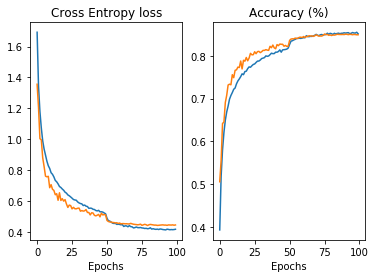

In [54]:
%%time
model = SimpleConvNet()
opt = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt,mode='max',patience=5,verbose=True,factor=0.1)
trained_model = train(model,opt,loss_fn, epochs=100, scheduler=lr_scheduler)